# Multi touch attribution modeling with Google analytics data

Understanding the sources that contribute to a high conversion rate is crucial for effective decision-making in resource allocation. It's essential to gain insights into the channels where investments are made and the returns generated. This project aims to analyze various channels using different models, providing valuable information to optimize our credit system. Through this paper, we will explore and evaluate diverse channels to enhance our understanding of their impact on conversion rates.

To familiarize yourself with [Channel Attribution](https://channelattribution.io/pdf/ChannelAttributionWhitePaper.pdf), it's essential to understand various attribution models:

* **First Touch Conversion:** This model attributes user conversion credit to the first touchpoint from which the user initially arrived.
* **Last Touchpoint Conversion:** User credit is attributed to the last touchpoint before conversion.
* **Linear Touchpoint:** Conversion credit is evenly distributed across all touchpoints that the user interacted with.
* **Markov Model:** A probabilistic model that assigns credit based on the paths most conversions have taken. Refer to the graph below for a visual representation.



🚀 Let's Dive into the Code! 📊👩‍💻 

In [1]:
import numpy as np 
import pandas as pd

# Creating Google cloud instance for Bigquery
from google.cloud import bigquery

from plotly import graph_objects as go
import plotly.io as pio
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

%matplotlib inline

# connecting with igquery client
client = bigquery.Client()


Using Kaggle's public dataset BigQuery integration.


In [2]:
%%capture
# Channel attribution models : https://channelattribution.io/
!pip install ChannelAttribution
from ChannelAttribution import *

🔍 SQL Query: Retrieve Sessions with Conversions using Common Table Expression 📊

In [3]:
#SQL to get all the sessions with conversions.
# Using Common table expresiion for retriving the query
session_medum='''

 WITH convrsion_summed AS(
 SELECT 
   fullVisitorId, visitNumber,
               totals.transactions AS conversion, 
               totals.totalTransactionRevenue/1000000 AS value,
               trafficSource.medium AS medium,
               SUM(CASE WHEN totals.transactions IS NULL
                       THEN 0 ELSE 1 END)
                 OVER(PARTITION BY fullVisitorId
                         ORDER BY visitNumber
                         ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW  
                         )AS convosofar,
                FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
                WHERE   _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
                       )
                       
SELECT fullVisitorId,visitNumber,  conversion, value,
           medium
FROM convrsion_summed 
WHERE convosofar=0 
OR convosofar=1

'''
session_medium_df = client.query(session_medum).result().to_dataframe()
session_medium_df.head()

,fullVisitorId,visitNumber,conversion,value,medium
0,9476348446859765776,11,NaN,NaN,(not set)
1,9476348446859765776,12,NaN,NaN,(not set)
2,9476348446859765776,13,NaN,NaN,(not set)
3,6335006349301752754,2,NaN,NaN,(not set)
4,2252397032713461364,6,NaN,NaN,(not set)


# 🛠️ Data Preparation

In [4]:
session_medium_df['medium'].value_counts().head()

medium
(none)       368743
referral     261929
organic      233803
affiliate     16403
cpc           13024
Name: count, dtype: int64

In [5]:
session_medium_df['visitNumber'].value_counts().head()

visitNumber
1    703057
2     92388
3     35594
4     18861
5     11321
Name: count, dtype: int64

In [6]:
# Lets copy the data to seccure and use
Medium_df=session_medium_df.copy()

In [7]:
# Na columns are dounting the model quality so lets fill with "0"
Medium_df=Medium_df.fillna(0)

map_dictionary = {'organic': 'Search', '(none)': 'Direct', 
                  'referral': 'Referral', 'cpc':'Paid Search', 
                  'affiliate': 'Affiliate', 'cpm': 'Display Ad', '(not set)': 'Direct'}

Medium_df['medium']=Medium_df['medium'].map(map_dictionary)
Medium_df['medium'].value_counts()

medium
Direct         368857
Referral       261929
Search         233803
Affiliate       16403
Paid Search     13024
Display Ad       6059
Name: count, dtype: int64

In [8]:
# For this model I only concentrate on first conversion only for clarity purpose
#Updating the session to one if the sessions haveing more than one
Medium_df.loc[Medium_df['conversion'] >= 1,'conversion']  = 1
Medium_df['conversion'].value_counts()

conversion
0.0    890053
1.0     10022
Name: count, dtype: int64

In [9]:
medium_df=Medium_df
#Group by visitor aggregating all mediums
path_df = medium_df.groupby('fullVisitorId')['medium'].agg(lambda x: x.tolist()).reset_index()

path_df.head()

,fullVisitorId,medium
0,0000010278554503158,[Search]
1,0000020424342248747,[Direct]
2,0000027376579751715,[Direct]
3,0000039460501403861,[Referral]
4,0000040862739425590,"[Direct, Direct]"


In [10]:
# Drop all the columns except last one for each visitor
last_session_df = medium_df.drop_duplicates('fullVisitorId', keep='last')[['fullVisitorId', 'conversion', 'value']]

last_session_df.head()

,fullVisitorId,conversion,value
3,6335006349301752754,0.0,0.00
9,9813549014448545779,0.0,0.00
24,3659524263905388125,0.0,0.00
25,4317514585616275362,0.0,0.00
31,9907138721210043039,1.0,11.99


In [11]:
#Merging the two tables
path_df = pd.merge(path_df, last_session_df, how='left', on='fullVisitorId')
path_df.head()

,fullVisitorId,medium,conversion,value
0,0000010278554503158,[Search],0.0,0.0
1,0000020424342248747,[Direct],0.0,0.0
2,0000027376579751715,[Direct],0.0,0.0
3,0000039460501403861,[Referral],0.0,0.0
4,0000040862739425590,"[Direct, Direct]",0.0,0.0


In [12]:

# Modify the medium as per the channelattribution model
def listToString(df):  
    str1 = ""  
    for i in df['medium']:  
        str1 += i + ' > '    
    return str1[:-3]

path_df['medium'] = path_df.apply(listToString, axis=1)

path_df.head()
    

,fullVisitorId,medium,conversion,value
0,0000010278554503158,Search,0.0,0.0
1,0000020424342248747,Direct,0.0,0.0
2,0000027376579751715,Direct,0.0,0.0
3,0000039460501403861,Referral,0.0,0.0
4,0000040862739425590,Direct > Direct,0.0,0.0


In [13]:
path_df.drop(columns = 'fullVisitorId', inplace = True)

In [14]:

path_df['null'] = np.where(path_df['conversion'] == 0,1,0)

attribution_df = path_df.groupby(['medium'], as_index = False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", "null": "total_null", "value": "total_value"}, inplace = True)


attribution_df.sample(10)

,medium,total_conversions,total_value,total_null
987,Paid Search > Display Ad > Display Ad > Displa...,1.0,602.91,4
733,Display Ad > Display Ad > Direct > Direct > Di...,0.0,0.00,1
1028,Paid Search > Paid Search > Direct > Direct > ...,0.0,0.00,1
417,Direct > Direct > Direct > Referral > Referral,0.0,0.00,50
313,Direct > Direct > Direct > Direct > Direct > D...,0.0,0.00,34
1267,Referral > Affiliate > Affiliate > Affiliate >...,0.0,0.00,1
620,Direct > Search > Search > Search > Search > R...,0.0,0.00,2
1043,Paid Search > Paid Search > Direct > Search > ...,0.0,0.00,3
397,Direct > Direct > Direct > Direct > Search > S...,0.0,0.00,9
1334,Search > Affiliate > Affiliate > Affiliate,0.0,0.00,7


In [15]:
M=markov_model(attribution_df, "medium", "total_conversions", var_value="total_value", flg_adv=False)
H=heuristic_models(attribution_df,"medium","total_conversions",var_value="total_value", flg_adv=False)

Number of simulations: 100000 - Convergence reached: 1.68% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (5) is reached: 99.99%


In [16]:
# Graph the attribution of the different models
R=pd.merge(H,M,on="channel_name",how="inner")
R1=R[["channel_name","first_touch_conversions","last_touch_conversions", "linear_touch_conversions","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R1=pd.melt(R1, id_vars="channel_name")

data = [dict(type = "histogram", histfunc="sum",x = R1.channel_name, y = R1.value,
             transforms = [dict(type = "groupby", groups = R1.variable,)],)]

fig = dict({"data":data}) 
pio.show(fig,validate=False)

📊 Analysis from the Graph: Understanding Attribution Models 🤔

Upon examining the graph, it becomes evident how various models allocate conversion credit to different channels. Notably, the Markov attribution model appears to assign higher credit to the paid search channel based on our observations.

In [17]:
#looking at attribution based on value
R2=R[["channel_name","first_touch_value","last_touch_value","linear_touch_value","total_conversion_value"]]
#Renaming the columns
R2.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]
R2=pd.melt(R2, id_vars="channel_name")

#creating the list dictionary to configure the formates
data=[dict(
    type="histogram",histfunc="sum",
    x= R2.channel_name,
    y= R2.value,
    transforms = [dict(type = "groupby",groups = R2.variable,)],
)]
fig = dict({"data":data})
pio.show(fig,validate=False)

# Transition matrix

In [18]:
transition_matrix=transition_matrix(attribution_df, "medium", "total_conversions", var_null="total_null" , flg_adv=False)


In [19]:
matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, '(conversion)'),
  Text(1.5, 0, '(null)'),
  Text(2.5, 0, 'Affiliate'),
  Text(3.5, 0, 'Direct'),
  Text(4.5, 0, 'Search'),
  Text(5.5, 0, 'Referral'),
  Text(6.5, 0, 'Display Ad'),
  Text(7.5, 0, 'Paid Search')])

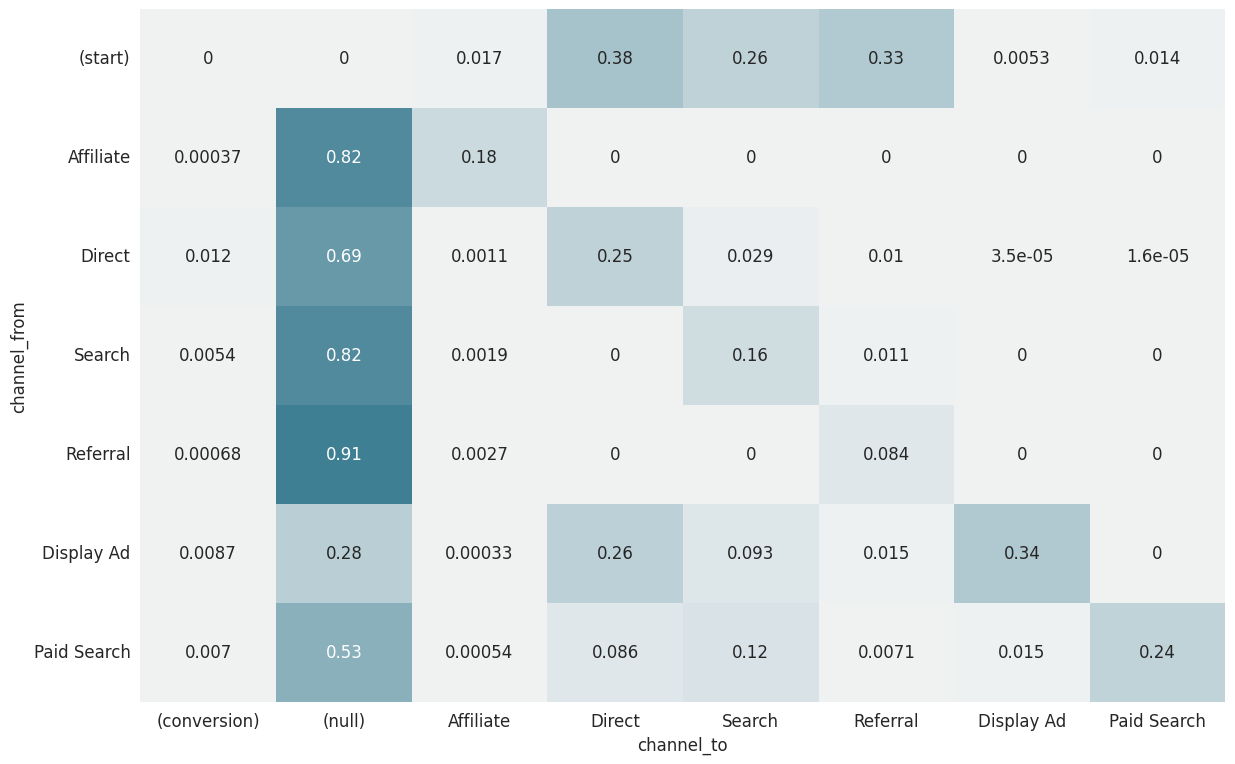

In [20]:
fig = plt.figure(figsize = (14,9))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, center = 0,\
            annot_kws={'size':12}, cbar=False)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)

# 🔍Conclusions

The insights derived from the heat map and plots provide a comprehensive understanding of each marketing channel's contribution to conversions. Beyond individual channel performance, we've gained crucial insights into the interplay between channels, uncovering the paths that guide users from one channel to another.

In today's landscape, where users encounter multiple touchpoints, this information holds immense value. It empowers us to optimize our multi-channel customer journeys effectively. The Markov Chain approach, as detailed in this article, enhances the accuracy of attributions, ensuring a more precise reflection of how users interact with our marketing efforts. 🚀📈